In [1]:
import numpy as np
import pymanopt 
import pandas as pd
import sys
sys.path.append('../')
from scripts import flag_dimensionality_reduction as fdr
from scripts.utils import *

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt


In [2]:

results = pd.DataFrame(columns = ['n Outliers', 'Algorithm', 'AUC'])

n = 4
k = 2
fl_type = [1,2]
n_pcs = fl_type[-1]

manifold = pymanopt.manifolds.grassmann.Grassmann(n,k)

n = 100
for n_out in [5,10,15,20,25,30,35,40,45,50]:
    
    data = outlier_gen(manifold,n-n_out, n_out)
    labels = np.array([0]*(n-n_out) + [1]*n_out)

    #PCA
    data_pca = [d.flatten() for d in data]

    pca = PCA(n_components = n_pcs)
    pcs = pca.fit_transform(np.vstack(data_pca)).T
    W = pca.components_.T

    data_pca = fdr.mean_center(data_pca)

    base_pca = [data_pca, W, pcs]

    row = pd.DataFrame(columns = results.columns,
                        data = [[n_out, 'PCA', run_roc_tangent(data_pca, W, labels)]])
    results = pd.concat([results, row])


    #t-PCA
    W, pgs, ts, mu = PGA0(manifold, data, [n_pcs], eps = 1e-9, return_ts = True)

    data_tpca = ts

    roc_val = run_roc_tangent(data, W, labels, tangent = True, manifold = manifold, t_data = data_tpca, mu = mu)

    base_tpca = [data_tpca, W, pgs]

    row = pd.DataFrame(columns = results.columns,
                        data = [[n_out, 't-PCA', roc_val]])
    results = pd.concat([results, row])


    median = fdr.karcher_median(manifold, data, eps = 1e-9)


    base_fres = {}
    alg_names = ['L1-WPCA', 'L2-WPCA', 'L1-RPCA', 'L2-RPCA', 'L1-DPCP', 'L2-DPCP']
    ii=0

    for pca_type in ['wpca', 'rpca', 'dpcp']:
        for fl_tp in [fl_type,[fl_type[-1]]]:

            data_fpca = [d.flatten() for d in data]

            #fPCA
            if pca_type == 'dpcp':
                data_fpca = np.vstack([x/np.linalg.norm(x) for x in data_fpca]).T
            else:
                data_fpca = fdr.mean_center(data_fpca)


            W, errs, _ = fdr.flag_robust_pca(data_fpca,
                                    fl_tp, 
                                    pca_type,
                                    max_iters = 100,
                                    init= 'rand',
                                    verbose = False,
                                    return_all = True)
                                    
            if len(errs) == 100:
                print(f'{pca_type}{fl_type} not converged')
            pcs = W.T @ data_fpca

            base_fpca = [data_fpca, W, pcs]
            
            row = pd.DataFrame(columns = results.columns,
                                data = [[n_out, alg_names[ii], run_roc_tangent(data_fpca, W, labels, pca_type)]])
            results = pd.concat([results, row])

            #t-fPCA
            [W, _, _], t_data = fdr.flag_robust_tpca(manifold,
                                            data,
                                            fl_tp, 
                                            pca_type,
                                            init= 'rand',
                                            max_iters = 100,
                                            return_ts= True,
                                            verbose = False,
                                            eps = 1e-9)
            if len(errs) == 100:
                print(f't-{pca_type}{fl_type} not converged')

            pgs = W.T @ t_data

            base_tfpca = [t_data, W, pgs]


            roc_val = run_roc_tangent(data, W, labels, pca_type, tangent = True, manifold = manifold, t_data = t_data, mu = median)
            
            row = pd.DataFrame(columns = results.columns,
                    data = [[n_out, f't-{alg_names[ii]}', roc_val]])
            results = pd.concat([results, row])

            base_fres[pca_type+str(fl_type)] = [base_fpca, base_tfpca]

            ii+=1

            print(results)



  n Outliers  Algorithm       AUC
0          5        PCA  0.842105
0          5      t-PCA  0.953684
0          5    L1-WPCA  1.000000
0          5  t-L1-WPCA  1.000000
  n Outliers  Algorithm       AUC
0          5        PCA  0.842105
0          5      t-PCA  0.953684
0          5    L1-WPCA  1.000000
0          5  t-L1-WPCA  1.000000
0          5    L2-WPCA  1.000000
0          5  t-L2-WPCA  1.000000
  n Outliers  Algorithm       AUC
0          5        PCA  0.842105
0          5      t-PCA  0.953684
0          5    L1-WPCA  1.000000
0          5  t-L1-WPCA  1.000000
0          5    L2-WPCA  1.000000
0          5  t-L2-WPCA  1.000000
0          5    L1-RPCA  1.000000
0          5  t-L1-RPCA  1.000000
  n Outliers  Algorithm       AUC
0          5        PCA  0.842105
0          5      t-PCA  0.953684
0          5    L1-WPCA  1.000000
0          5  t-L1-WPCA  1.000000
0          5    L2-WPCA  1.000000
0          5  t-L2-WPCA  1.000000
0          5    L1-RPCA  1.000000
0          5  

In [5]:
results.to_csv('../Results/gr_outlier_detection.csv')

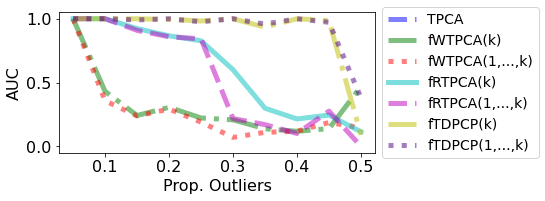

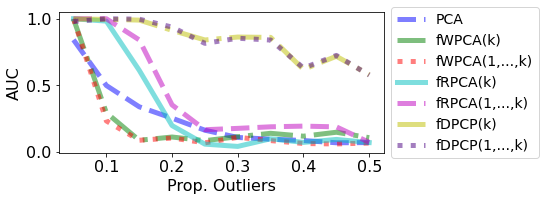

In [12]:
results = pd.read_csv('../Results/gr_outlier_detection.csv')
plt.rcParams.update({'font.size': 16})

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'indigo', 'maroon', 'teal', 'orange', 'purple', 'brown']
linestyles = ['--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
ii = 0

plt.figure(0, figsize = (8,3))
plt.figure(1, figsize = (8,3))

# plt.figure(figsize = (8,3))

for alg in ['PCA', 'TPCA']:
    y = results[results['Algorithm'] == alg]['AUC']
    x = results[results['Algorithm'] == alg]['n Outliers']/100
    if 'T' in alg:
        plt.figure(0)
        plt.plot(x,y,label = alg, c = colors[ii], linestyle = linestyles[ii], alpha = .5, linewidth=5.0)
    else:
        plt.figure(1)
        plt.plot(x,y,label = alg, c = colors[ii], linestyle = linestyles[ii], alpha = .5, linewidth=5.0)

ii+=1
alg_names = [['fWTPCA(k)', 'fWTPCA(1,...,k)', 'fRTPCA(k)', 'fRTPCA(1,...,k)', 'fTDPCP(k)', 'fTDPCP(1,...,k)'],['fWPCA(k)', 'fWPCA(1,...,k)', 'fRPCA(k)', 'fRPCA(1,...,k)', 'fDPCP(k)', 'fDPCP(1,...,k)']]
for jj, alg in zip(np.arange(6), ['L2-WPCA', 'L1-WPCA', 'L2-RPCA', 'L1-RPCA', 'L2-DPCP', 'L1-DPCP']):
    for ax, t in zip([0,1],alg_names):
        pref = ['t-','']
        t = pref[ax]
        plt.figure(ax)
        y = results[results['Algorithm'] == f'{t}{alg}']['AUC']
        x = results[results['Algorithm'] == f'{t}{alg}']['n Outliers']/100
        plt.plot(x,y,label = alg_names[ax][jj], c = colors[ii], linestyle = linestyles[ii], alpha = .5, linewidth=5.0)

    ii+=1

# ax1.legend()
plt.figure(0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.xlabel('Prop. Outliers')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig('../Results/gr_outlier_detection_man.pdf', bbox_inches = 'tight')


plt.figure(1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.xlabel('Prop. Outliers')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig('../Results/gr_outlier_detection_euc.pdf', bbox_inches = 'tight')

